<a href="https://colab.research.google.com/github/jaykay4403/Bayesian-ML/blob/main/Football_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import pandas_profiling
from pandas_profiling import ProfileReport 

import matplotlib.pyplot as plt

import warnings

from collections import OrderedDict
from time import time

import arviz as az
import pymc3 as pm
import seaborn as sns
import theano as thno
import theano.tensor as T

from scipy import integrate
from scipy.optimize import fmin_powell

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
# pandas profiling
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

# Fix for Pandas profiling error
# See: https://www.datasciencelearner.com/importerror-cannot-import-name-soft-unicode-from-markupsafe-solved/

#!pip install --user --upgrade aws-sam-cli

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
pbp_2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/2020 PFF Data.csv", index_col=0)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (180) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# Full_pbp = pd.concat([pbp_2016, pbp_2017, pbp_2018, pbp_2019, pbp_2020, pbp_2021])

In [8]:
# Full_pbp.columns

In [9]:
Run_Pass_Columns = ['down','distance','field_position','garbage_time','run_pass']

In [10]:
Run_Pass = pbp_2020[Run_Pass_Columns]
Run_Pass = Run_Pass[~Run_Pass.run_pass.isnull()]
Run_Pass = Run_Pass[Run_Pass['garbage_time'] == 0]
Run_Pass.head(5)

,down,distance,field_position,garbage_time,run_pass
plays.63371,1,10,-25,0,R
plays.63372,1,10,-19,0,R
plays.63268,2,4,-25,0,P
plays.63269,1,10,48,0,P
plays.63877,2,10,48,0,P


In [11]:
def f(row):
    if row['field_position'] < 0:
        val = (100 + row['field_position'])
    else:
        val = row['field_position']
    return val

In [12]:
Run_Pass.head(5)

,down,distance,field_position,garbage_time,run_pass
plays.63371,1,10,-25,0,R
plays.63372,1,10,-19,0,R
plays.63268,2,4,-25,0,P
plays.63269,1,10,48,0,P
plays.63877,2,10,48,0,P


In [13]:
Run_Pass['NewFPos'] = Run_Pass.apply(f, axis=1)

In [14]:
run_pass = 1 * (Run_Pass['run_pass'] == "P")

In [15]:
Run_Pass["run_pass"] = run_pass

In [16]:
Run_Pass.head(5)

,down,distance,field_position,garbage_time,run_pass,NewFPos
plays.63371,1,10,-25,0,0,75
plays.63372,1,10,-19,0,0,81
plays.63268,2,4,-25,0,1,75
plays.63269,1,10,48,0,1,48
plays.63877,2,10,48,0,1,48


In [17]:
warnings.filterwarnings("ignore")


In [18]:
%matplotlib inline
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

In [19]:
def run_models(df, upper_order=5):
    """
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity.
    Suggest limit to max order 5 since calculation time is exponential.
    """

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1, upper_order + 1):

        nm = f"k{k}"
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print(f"\nRunning: {nm}")
            pm.glm.GLM.from_formula(fml, df, family=pm.glm.families.Binomial())

            traces[nm] = pm.sample(1000, tune=1000, init="adapt_diag", return_inferencedata=True)

    return models, traces


def plot_traces(traces, model, retain=0):
    """
    Convenience function:
    Plot traces with overlaid means and values
    """
    with model:
        ax = az.plot_trace(
            traces[-retain:],
            lines=tuple([(k, {}, v["mean"]) for k, v in az.summary(traces[-retain:]).iterrows()]),
        )

        for i, mn in enumerate(az.summary(traces[-retain:])["mean"]):
            ax[i, 0].annotate(
                f"{mn:.2f}",
                xy=(mn, 0),
                xycoords="data",
                xytext=(5, 10),
                textcoords="offset points",
                rotation=90,
                va="bottom",
                fontsize="large",
                color="#AA0022",
            )


def create_poly_modelspec(k=1):
    """
    Convenience function:
    Create a polynomial modelspec string for patsy
    """
    return (
        "run_pass ~ down + distance " + " ".join([f"+ np.power(age,{j})" for j in range(2, k + 1)])
    ).strip()

In [33]:
with pm.Model() as logistic_model:
  
    priors = {'down': pm.Beta.dist(alpha=1.0, beta=1.0),
             'distance': pm.Normal.dist(mu=0.0, sigma=1.0)}
             
    pm.glm.GLM.from_formula(
        "run_pass ~ down + distance", Run_Pass, family=pm.glm.families.Binomial()
    )
    trace = pm.sample(1000, tune=1000, init="adapt_diag")

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [distance, down, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 723 seconds.


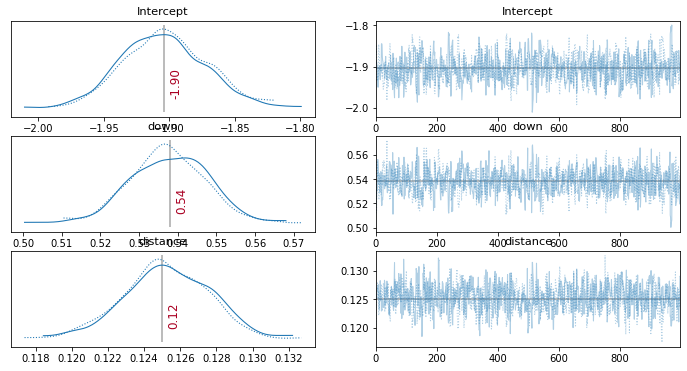

In [34]:
plot_traces(trace, logistic_model)

Text(27.125, 0.5, 'beta_distance')

<Figure size 648x504 with 0 Axes>

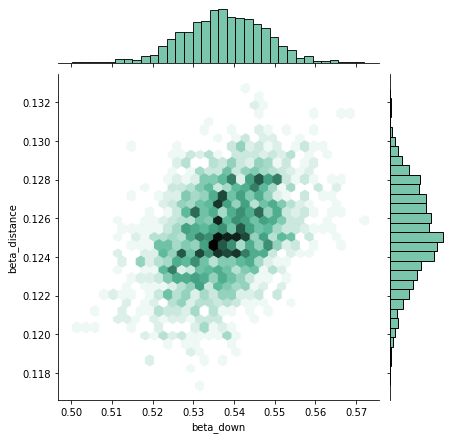

In [35]:
plt.figure(figsize=(9, 7))
sns.jointplot(trace["down"], trace["distance"], kind="hex", color="#4CB391")
plt.xlabel("beta_down")
plt.ylabel("beta_distance")

In [20]:
# forest plot
pm.plotes

In [36]:
def lm_full(trace, down, distance):
    shape = np.broadcast(down, distance).shape
    x_norm = np.asarray([np.broadcast_to(x, shape) for x in [down, distance]])
    return 1 / (
        1
        + np.exp(
            -(
                trace["Intercept"]
                + trace["down"] * x_norm[0]
                + trace["distance"] * x_norm[1]
            )
        )
    )


lm = lambda x, samples: lm_full(samples, 1, x)

lm2 = lambda x, samples: lm_full(samples, 2, x)

lm3 = lambda x, samples: lm_full(samples, 3, x)

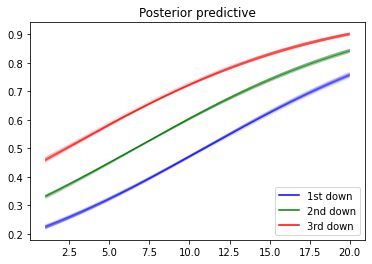

In [37]:
# Plot the posterior predictive distributions of P(income > $50K) vs. age
pm.plot_posterior_predictive_glm(
    trace, eval=np.linspace(1, 20, 1000), lm=lm, samples=100, color="blue", alpha=0.15
)
pm.plot_posterior_predictive_glm(
    trace,
    eval=np.linspace(1, 20, 1000),
    lm=lm2,
    samples=100,
    color="green",
    alpha=0.15,
)
pm.plot_posterior_predictive_glm(
    trace, eval=np.linspace(1, 20, 1000), lm=lm3, samples=100, color="red", alpha=0.15
)

import matplotlib.lines as mlines

blue_line = mlines.Line2D(["lm"], [], color="b", label="1st down")
green_line = mlines.Line2D(["lm2"], [], color="g", label="2nd down")
red_line = mlines.Line2D(["lm3"], [], color="r", label="3rd down")
plt.legend(handles=[blue_line, green_line, red_line], loc="lower right")
plt.show()

KeyError: ignored

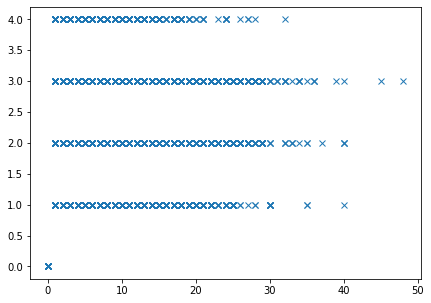

In [93]:
plt.figure(figsize=(7, 5))
plt.plot(Run_Pass['distance'], Run_Pass['down'], "x", label="data")
pm.plot_posterior_predictive_glm(trace_lite, samples=100, label="posterior predictive regression lines")
#plt.plot(x, true_regression_line, label="true regression line", lw=3.0, c="y")

plt.legend(loc=0);

In [47]:
import matplotlib as mpl
#figsize(12.5, 4.5)
#plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(trace["logistic_model"][::400, np.argsort(data)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40),
       ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");

KeyError: ignored

In [ ]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = trace["assignment"]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point");

In [81]:
Run_Pass_lite = Run_Pass.drop(Run_Pass.index[0:75000], inplace=False)
Run_Pass_lite

,down,distance,field_position,garbage_time,run_pass,NewFPos
plays.4136,1,5,5,0,0,5
plays.4204,1,10,-25,0,1,75
plays.4547,2,2,-33,0,0,67
plays.4197,3,4,-31,0,1,69
plays.4222,1,10,-32,0,0,68
...,...,...,...,...,...,...
plays.10182,1,10,50,0,0,50
plays.10265,2,7,47,0,1,47
plays.9523,3,7,47,0,0,47
plays.10204,4,7,47,0,1,47


In [85]:
with pm.Model() as logistic_model_lite:
    
    priors = {'down': pm.Beta.dist(alpha=1.0, beta=1.0),
             'distance': pm.Normal.dist(mu=0.0, sigma=1.0)}

    pm.glm.GLM.from_formula(
        
        "run_pass ~ down + distance", Run_Pass_lite, family=pm.glm.families.Binomial()
    )
    trace_lite = pm.sample(1000, tune=1000, init="adapt_diag")

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [distance, down, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 57 seconds.


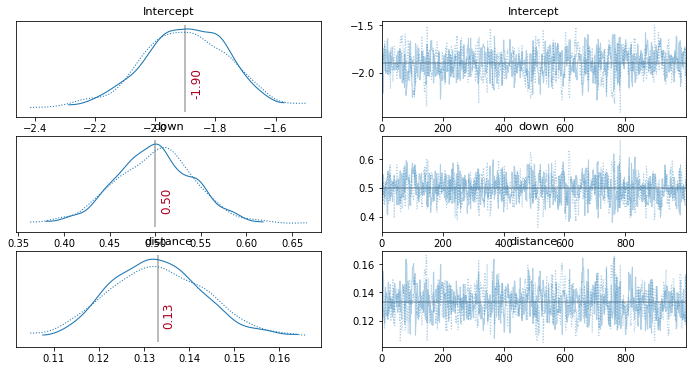

In [86]:
plot_traces(trace_lite, logistic_model_lite)

In [87]:
with logistic_model_lite:
    ppc = pm.sample_posterior_predictive(trace_lite, samples=500)

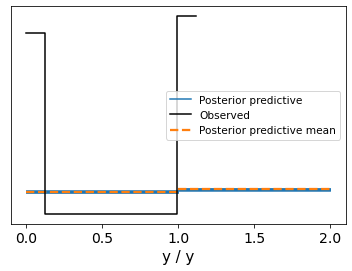

In [88]:
import arviz as az
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=logistic_model_lite))

NameError: ignored

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2cd5ffef50>,
      dtype=object)

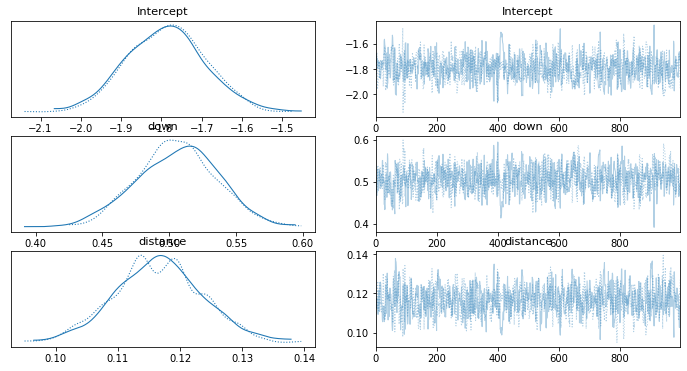

In [54]:
pm.plots.traceplot(trace)

In [94]:
## Compare model fit: DIC vs. WAIC
# See: https://pymc3-testing.readthedocs.io/en/rtd-docs/notebooks/GLM-model-selection.html

# Deviance Information Criterion [DIC] - compares the deviance of likelhood
# across the the sample traces of a model run
#pm.stats.dic(model=logistic_model, trace=trace)
#pm.stats.dic(trace)

# Watanabe - Akaike Information Criterion (WAIC) - calculates the
# goodness-of-fit of amodel using numerical techniques
#pm.stats.waic(model=logistic_model, trace=trace)
pm.stats.waic(trace, pointwise=False)

Got error No model on context stack. trying to find log_likelihood in translation.


Computed from 2000 by 9201 log-likelihood matrix

          Estimate       SE
elpd_waic -6134.24    23.48
p_waic        3.54        -

In [115]:
sigma_y = y.std(axis=1)
sigma_y

plays.63371   nan
plays.21228   nan
plays.21459   nan
plays.21684   nan
plays.21229   nan
               ..
plays.10182   nan
plays.10265   nan
plays.9523    nan
plays.10204   nan
plays.9312    nan
Length: 19202, dtype: float64

In [24]:
plot_Run_Pass = Run_Pass.drop(['field_position', 'garbage_time', 'NewFPos'], axis=1)
plot_Run_Pass

,down,distance,run_pass
plays.63371,1,10,0
plays.63372,1,10,0
plays.63268,2,4,1
plays.63269,1,10,1
plays.63877,2,10,1
...,...,...,...
plays.10182,1,10,0
plays.10265,2,7,1
plays.9523,3,7,0
plays.10204,4,7,1


Text(0.5, 1.0, 'Run vs. Pass')

<Figure size 1080x1080 with 0 Axes>

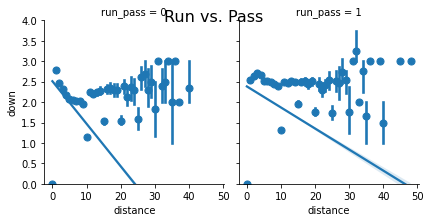

In [101]:
plt.figure(figsize = (15,15))

g = sns.FacetGrid(plot_Run_Pass, col="run_pass", col_wrap=2)
g.map_dataframe(
    sns.regplot, x= 'distance', y="down", x_estimator=np.mean)
g.set_axis_labels(
        x_var='distance', y_var='down'
        )

# control x and y limits
#plt.xlim(0, None)
plt.ylim(0, 4)

g.fig.subplots_adjust(top=.95)
g.fig.suptitle('Run vs. Pass', y=1.0, fontsize=16)

Text(0.5, 1.0, 'Run vs. Pass')

<Figure size 1080x1080 with 0 Axes>

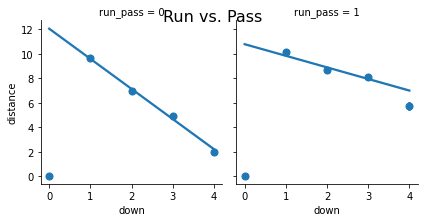

In [134]:
plt.figure(figsize = (15,15))
g = sns.FacetGrid(plot_Run_Pass, col="run_pass", col_wrap=2)
g.map_dataframe(
    sns.regplot, x= 'down', y="distance", x_estimator=np.mean)
g.set_axis_labels(
        x_var='down', y_var='distance'
        )
    
g.fig.subplots_adjust(top=.95)
g.fig.suptitle('Run vs. Pass', y=1.0, fontsize=16)

In [25]:
# setup for long play plot

plot_Run_Pass_long = plot_Run_Pass
plot_Run_Pass_long['long_distance'] = plot_Run_Pass_long['distance'] > 10
plot_Run_Pass_long

,down,distance,run_pass,long_distance
plays.63371,1,10,0,False
plays.63372,1,10,0,False
plays.63268,2,4,1,False
plays.63269,1,10,1,False
plays.63877,2,10,1,False
...,...,...,...,...
plays.10182,1,10,0,False
plays.10265,2,7,1,False
plays.9523,3,7,0,False
plays.10204,4,7,1,False


In [103]:
# different way to do it than above
long_plot_Run_Pass = plot_Run_Pass.loc[plot_Run_Pass.long_distance == True]
long_plot_Run_Pass

,down,distance,run_pass,long_distance
plays.63376,2,11,1,True
plays.63894,1,15,1,True
plays.63011,1,15,1,True
plays.63870,2,13,1,True
plays.63366,2,12,0,True
...,...,...,...,...
plays.9288,2,12,0,True
plays.9154,3,17,0,True
plays.10017,2,11,0,True
plays.10217,2,14,1,True


In [105]:
long_plot_Run_Pass['long_distance'].value_counts()

True    8220
Name: long_distance, dtype: int64

Text(0.5, 1.0, 'Run vs. Pass: Long Play')

<Figure size 1440x1440 with 0 Axes>

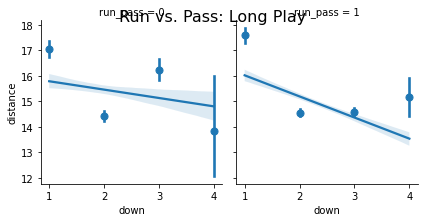

In [104]:
plt.figure(figsize = (20,20))
g = sns.FacetGrid(long_plot_Run_Pass, col="run_pass", col_wrap=2)
g.map_dataframe(
    sns.regplot, x= 'down', y="distance", x_estimator=np.mean)
g.set_axis_labels(
        x_var='down', y_var='distance'
        )
    
g.fig.subplots_adjust(top=.95)
g.fig.suptitle('Run vs. Pass: Long Play', y=1.0, fontsize=16)

In [152]:
long_plot_Run_Pass

,down,distance,run_pass,long_distance
plays.63376,2,11,1,True
plays.63894,1,15,1,True
plays.63011,1,15,1,True
plays.63870,2,13,1,True
plays.63366,2,12,0,True
...,...,...,...,...
plays.9288,2,12,0,True
plays.9154,3,17,0,True
plays.10017,2,11,0,True
plays.10217,2,14,1,True


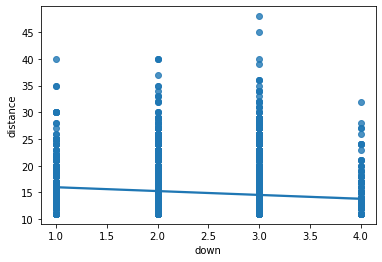

In [153]:
ax = sns.regplot(x="down", y="distance", data=long_plot_Run_Pass, 
                 logistic=False, n_boot=500, y_jitter=.03)

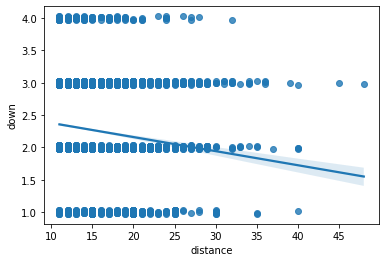

In [154]:
ax = sns.regplot(x="distance", y="down", data=long_plot_Run_Pass, 
                 logistic=False, n_boot=500, y_jitter=.03)

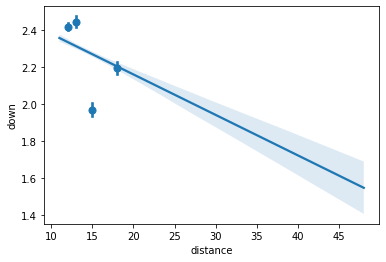

In [155]:
ax = sns.regplot(x="distance", y="down", data=long_plot_Run_Pass, 
                 logistic=False, n_boot=500, y_jitter=.03, x_bins = 4)

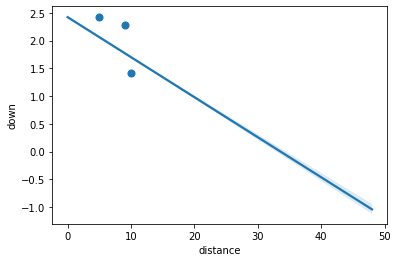

In [156]:
ax = sns.regplot(x="distance", y="down", data=plot_Run_Pass, 
                 logistic=False, n_boot=500, y_jitter=.03, x_bins = 4)

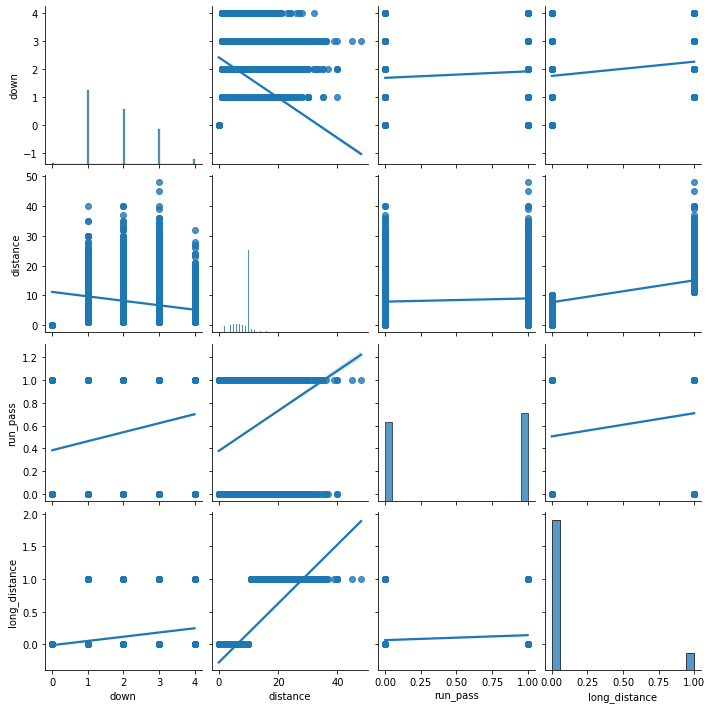

In [161]:
ax = sns.pairplot(data=plot_Run_Pass, kind = 'reg')

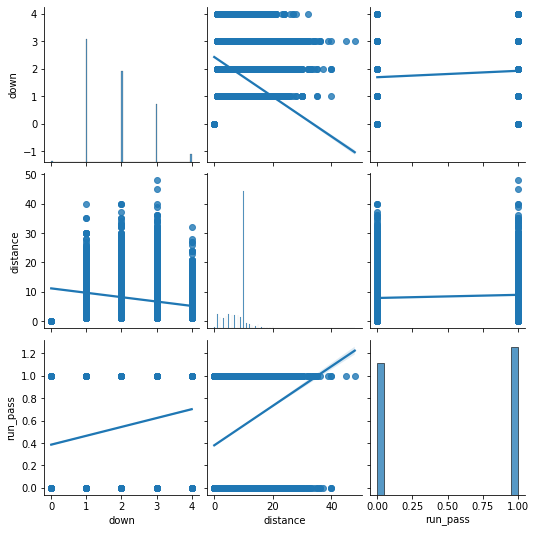

In [165]:
ax = sns.pairplot(data=plot_Run_Pass.drop(['long_distance'], axis = 1), kind = 'reg')

In [168]:
Run_Pass['run_pass']

plays.63371    0
plays.63372    0
plays.63268    1
plays.63269    1
plays.63877    1
              ..
plays.10182    0
plays.10265    1
plays.9523     0
plays.10204    1
plays.9312     0
Name: run_pass, Length: 79201, dtype: int64

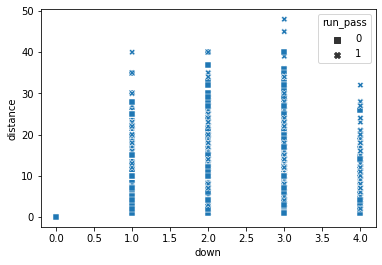

In [170]:
markers = {0: "s", 1: "X"}
sns.scatterplot(data=Run_Pass, x="down", y="distance", style="run_pass", markers=markers)

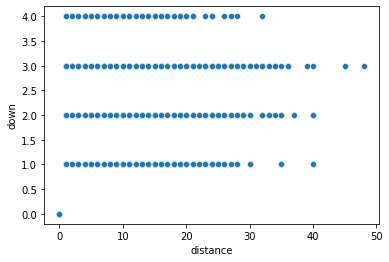

In [175]:
#markers = {0: "s", 1: "X"}
sns.scatterplot(data=Run_Pass, x="distance", y="down")
#run_pass = 1 * (Run_Pass['run_pass'] == "P")

In [125]:
plot_Run_Pass.count()

down        79201
distance    79201
run_pass    79201
dtype: int64

In [27]:
X_simple_lite

,down,distance
plays.63371,1,10
plays.21228,3,3
plays.21459,4,4
plays.21684,1,10
plays.21229,2,2
...,...,...
plays.10182,1,10
plays.10265,2,7
plays.9523,3,7
plays.10204,4,7


In [ ]:
## do not run, too big, crashes

%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#jet = plt.cm.jet
#fig = plt.figure()
x = X_simple_lite['down']  #plot_Run_Pass['down']
y = y_lite  #plot_Run_Pass['run_pass']
X, Y = np.meshgrid(x, y)

# figsize(12.5, 5)
# fig = plt.figure()
# plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
#plt.xlabel("prior on $p_1$")
#plt.ylabel("prior on $p_2$")
plt.title("$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view");

             down  distance  run_pass  long_distance
plays.63371     1        10         0          False
plays.63372     1        10         0          False
plays.63268     2         4         1          False
plays.63269     1        10         1          False
plays.63877     2        10         1          False
plays.63266     1        10         1          False
plays.63663     2        10         1          False
plays.63504     3        10         1          False
plays.63536     4         7         1          False
plays.62846     1        10         0          False ...


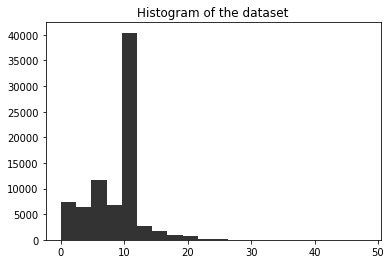

In [29]:
plt.hist(plot_Run_Pass['distance'], bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
print(plot_Run_Pass[:10], "...")

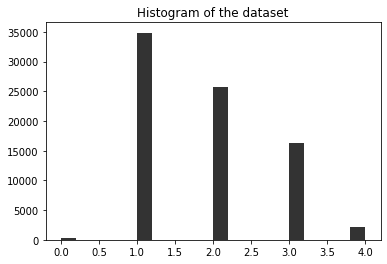

In [31]:
plt.hist(plot_Run_Pass['down'], bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
#print(plot_Run_Pass[:10], "...")

In [126]:
plot_Run_Pass['distance'].value_counts()

10    38801
1      3990
5      3937
7      3868
6      3778
8      3681
4      3351
2      3193
9      3096
3      2998
11     1620
15     1290
12     1181
13      810
14      671
20      575
16      427
17      348
18      309
0       288
19      257
21      158
25      134
22      113
23       85
24       73
26       46
27       25
28       25
29       21
30       14
32        9
34        5
35        5
40        5
33        4
31        3
36        3
45        1
37        1
39        1
48        1
Name: distance, dtype: int64

In [127]:
plot_Run_Pass['down'].value_counts()

1    34866
2    25698
3    16224
4     2125
0      288
Name: down, dtype: int64

In [20]:
Run_Pass.head

<bound method NDFrame.head of              down  distance  field_position  garbage_time  run_pass  NewFPos
plays.63371     1        10             -25             0         0       75
plays.63372     1        10             -19             0         0       81
plays.63268     2         4             -25             0         1       75
plays.63269     1        10              48             0         1       48
plays.63877     2        10              48             0         1       48
...           ...       ...             ...           ...       ...      ...
plays.10182     1        10              50             0         0       50
plays.10265     2         7              47             0         1       47
plays.9523      3         7              47             0         0       47
plays.10204     4         7              47             0         1       47
plays.9312      1        10             -26             0         0       74

[79201 rows x 6 columns]>

In [107]:
## install lazy classifier - run this every new session

#!pip install lazypredict


     |████████████████████████████████| 248 kB 13.1 MB/s 
     |████████████████████████████████| 269 kB 40.7 MB/s 
     |████████████████████████████████| 14.5 MB 62.9 MB/s 
     |████████████████████████████████| 302 kB 58.3 MB/s 
     |████████████████████████████████| 25.9 MB 1.1 MB/s 
     |████████████████████████████████| 6.8 MB 36.4 MB/s 
     |████████████████████████████████| 72 kB 855 kB/s 
     |████████████████████████████████| 127.6 MB 23 kB/s 
     |████████████████████████████████| 1.2 MB 33.3 MB/s 
     |████████████████████████████████| 10.1 MB 38.4 MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44636 sha256=bbbd111bb4e39aa538a9bc7947b4a3d91d6db4b39a4903585ee61c09f343cd8a
  Stored in directory: /root/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built PyYAML
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully 

In [19]:
# setup & run lazy classifier

### importing lazypredict library
import lazypredict
### importing LazyClassifier for classification problem
from lazypredict.Supervised import LazyClassifier
### importing LazyClassifier for classification problem because here we are solving Classification use case.
from lazypredict.Supervised import LazyClassifier

In [20]:
# Step 1: set up dataframes
y = Run_Pass[['run_pass']]
X_all = Run_Pass.drop(['run_pass'], axis=1)
X_simple = Run_Pass[['down','distance']]

In [1]:
# Reduce size of dataframe because of memory constrainst
# Causes colab to crash > 20000+ observations

#y.drop([40000,79200], axis=1, inplace=True)
#y.iloc[40000:]
#y.drop(y.index[20000:79200], inplace=True)
y_lite = y.drop(y.index[1:70000], inplace=False)
y_lite

NameError: ignored

In [22]:
#X_simple.drop(X_simple.index[20000:79200], inplace=True)
#X_simple
X_simple_lite = X_simple.drop(X_simple.index[1:60000], inplace=False)
X_simple_lite

,down,distance
plays.63371,1,10
plays.21228,3,3
plays.21459,4,4
plays.21684,1,10
plays.21229,2,2
...,...,...
plays.10182,1,10
plays.10265,2,7
plays.9523,3,7
plays.10204,4,7


In [23]:
from sklearn.model_selection import train_test_split

# Step 2: create train-test split - test = 20% / train = 80%
X_train, X_test, y_train, y_test = train_test_split(X_simple, y, train_size = 0.5, random_state = 14 )

In [24]:
# create an object of LazyClassifier class
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric = None)

In [ ]:
### fitting data in LazyClassifier
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

 41%|████▏     | 12/29 [01:43<05:55, 20.93s/it]

In [30]:
# 
isinstance(y, pd.DataFrame)

True

In [37]:
y

,run_pass
plays.63371,0
plays.63372,0
plays.63268,1
plays.63269,1
plays.63877,1
...,...
plays.10182,0
plays.10265,1
plays.9523,0
plays.10204,1


In [82]:
from pandas_profiling import ProfileReport
pd.options.display.max_columns = None

# Pandas Profiling
profile = ProfileReport(pbp_2020, title='Pandas Profiling Report',
                        html={'style':{'full_width':True}}, explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [83]:
profile.to_file(output_file="football_summary.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
print(repr(profile.report))

Root
